In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.python.keras.layers import Dense
from numpy.random import default_rng
from sklearn.model_selection import train_test_split

/Users/fernandokenjisakabe/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Loading pipeline params.
DATA_PATH = Path('data')
FILENAME_STOP = 'stop_90_diff_quat.csv'
FILENAME_0 = '0_90_diff_quat.csv'
FILENAME_90 = '90_90_diff_quat.csv'
FILENAME_180 = '180_90_diff_quat.csv'
FILENAME_270 = '270_90_diff_quat.csv'

# # Loading pipeline params.
# DATA_PATH = Path('data')
# FILENAME_STOP = 'stop.csv'
# FILENAME_0 = 'm_0.csv'
# FILENAME_90 = 'm_90.csv'
# FILENAME_180 = 'm_180.csv'
# FILENAME_270 = 'm_270.csv'


NUM_TIMESTEPS = 6
IGNORE_FRACTION = 0.1
TEST_FRACTION = 0.25
VALIDATION_FRACTION = 0.25


# Training params.
LEARNING_RATE = 1e-5
EPOCHS = 100
BATCH_SIZE = 512

In [4]:
def load_data(
    path_stop,
    path_0,
    path_90,
    path_180,
    path_270,
    num_timesteps,
    ignore_fraction,
    test_fraction,
):

    def read_and_prepare_data(
        path,
        class_,
        num_timesteps,
        ignore_fraction,
        test_fraction,
    ):

        def split_temporally(X, test_fraction):
            num_samples = X.shape[0]
            num_train = int(num_samples * (1.0 - test_fraction))
            X_train, X_test = X[:num_train], X[num_train:]
            return X_train, X_test

        def transform_into_sequences(X, num_timesteps):
            num_samples = X.shape[0]
            X_seq = []
            for k in range(num_samples - num_timesteps + 1):
                X_seq.append(X[k:(k + num_timesteps)])
            X_seq = np.array(X_seq)
            y_seq = class_ * np.ones((X_seq.shape[0], 1))
            return X_seq, y_seq

        X = pd.read_csv(path).values
        X = X[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13]]

        # Ignore beginning and end.
        num_samples = X.shape[0]
        num_ignore = int(ignore_fraction * num_samples)
        X = X[num_ignore:-num_ignore]

        # Split X temporally.
        X_train, X_test = split_temporally(X, test_fraction)
        
        # Transform X into short sequences.
        X_train, y_train = transform_into_sequences(X_train, num_timesteps)
        X_test, y_test = transform_into_sequences(X_test, num_timesteps)
        X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
        return X_train, y_train, X_test, y_test, X_val, y_val

    def shuffle_data(X, y):
        idx = np.arange(len(X))
        default_rng().shuffle(idx)
        X_shuffled = X[idx, :]
        y_shuffled = y[idx]
        return X_shuffled, y_shuffled

    X_train_stop, y_train_stop, X_test_stop, y_test_stop, X_val_stop, y_val_stop = \
        read_and_prepare_data(
            path_stop,
            0.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )
    
    X_train_0, y_train_0, X_test_0, y_test_0, X_val_0, y_val_0 = \
        read_and_prepare_data(
            path_0,
            1.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )

    X_train_90, y_train_90, X_test_90, y_test_90, X_val_90, y_val_90 = \
        read_and_prepare_data(
            path_90,
            2.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )
    
    X_train_180, y_train_180, X_test_180, y_test_180, X_val_180, y_val_180 = \
        read_and_prepare_data(
            path_180,
            3.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )
    
    X_train_270, y_train_270, X_test_270, y_test_270,X_val_270, y_val_270  = \
        read_and_prepare_data(
            path_270,
            4.0,
            num_timesteps,
            ignore_fraction,
            test_fraction,
        )

    X_train = np.concatenate((X_train_stop, X_train_0, X_train_90, X_train_180, X_train_270), axis=0)
    y_train = np.concatenate((y_train_stop, y_train_0, y_train_90, y_train_180, y_train_270), axis=0)
    X_test = np.concatenate((X_test_stop, X_test_0, X_test_90, X_test_180, X_test_270), axis=0)
    y_test = np.concatenate((y_test_stop, y_test_0, y_test_90, y_test_180, y_test_270), axis=0)
    X_val = np.concatenate((X_val_stop, X_val_0, X_val_90, X_val_180, X_val_270), axis=0)
    y_val = np.concatenate((y_val_stop, y_val_0, y_val_90, y_val_180, y_val_270), axis=0)

    
    
    X_train, y_train = shuffle_data(X_train, y_train)
    X_test, y_test = shuffle_data(X_test, y_test)
    X_val, y_val = shuffle_data(X_val, y_val)
    return X_train, X_test,X_val, y_train, y_test, y_val


path_stop = Path(DATA_PATH, FILENAME_STOP)
path_0 = Path(DATA_PATH, FILENAME_0)
path_90 = Path(DATA_PATH, FILENAME_90)
path_180 = Path(DATA_PATH, FILENAME_180)
path_270 = Path(DATA_PATH, FILENAME_270)

X_train, X_test, X_val, y_train, y_test , y_val= load_data(
    path_stop,
    path_0,
    path_90,
    path_180,
    path_270,
    NUM_TIMESTEPS,
    IGNORE_FRACTION,
    TEST_FRACTION,
)

In [5]:
# def load_data(
#     path_stop,
#     path_0,
#     path_90,
#     path_180,
#     path_270,
#     num_timesteps,
#     ignore_fraction,
#     test_fraction,
# ):

#     def read_and_prepare_data(
#         path,
#         class_,
#         num_timesteps,
#         ignore_fraction,
#         test_fraction,
#     ):

#         def split_temporally(X, test_fraction):
#             num_samples = X.shape[0]
#             num_train = int(num_samples * (1.0 - test_fraction))
#             X_train, X_test = X[:num_train], X[num_train:]
#             return X_train, X_test

#         def transform_into_sequences(X, num_timesteps):
#             num_samples = X.shape[0]
#             X_seq = []
#             for k in range(num_samples - num_timesteps + 1):
#                 X_seq.append(X[k:(k + num_timesteps)])
#             X_seq = np.array(X_seq)
#             y_seq = class_ * np.ones((X_seq.shape[0], 1))
#             return X_seq, y_seq

#         X = pd.read_csv(path).values
#         X = X[:, [0,1,2,3,4,5,6,7,8,9,10,11,12,13]]

#         # Ignore beginning and end.
#         num_samples = X.shape[0]
#         num_ignore = int(ignore_fraction * num_samples)
#         X = X[num_ignore:-num_ignore]

#         # Split X temporally.
#         X_train, X_test = split_temporally(X, test_fraction)

#         # Transform X into short sequences.
#         X_train, y_train = transform_into_sequences(X_train, num_timesteps)
#         X_test, y_test = transform_into_sequences(X_test, num_timesteps)

#         return X_train, y_train, X_test, y_test

#     def shuffle_data(X, y):
#         idx = np.arange(len(X))
#         default_rng().shuffle(idx)
#         X_shuffled = X[idx, :]
#         y_shuffled = y[idx]
#         return X_shuffled, y_shuffled

#     X_train_stop, y_train_stop, X_test_stop, y_test_stop = \
#         read_and_prepare_data(
#             path_stop,
#             0.0,
#             num_timesteps,
#             ignore_fraction,
#             test_fraction,
#         )
    
#     X_train_0, y_train_0, X_test_0, y_test_0 = \
#         read_and_prepare_data(
#             path_0,
#             1.0,
#             num_timesteps,
#             ignore_fraction,
#             test_fraction,
#         )

#     X_train_90, y_train_90, X_test_90, y_test_90 = \
#         read_and_prepare_data(
#             path_90,
#             2.0,
#             num_timesteps,
#             ignore_fraction,
#             test_fraction,
#         )
    
#     X_train_180, y_train_180, X_test_180, y_test_180 = \
#         read_and_prepare_data(
#             path_180,
#             3.0,
#             num_timesteps,
#             ignore_fraction,
#             test_fraction,
#         )
    
#     X_train_270, y_train_270, X_test_270, y_test_270 = \
#         read_and_prepare_data(
#             path_270,
#             4.0,
#             num_timesteps,
#             ignore_fraction,
#             test_fraction,
#         )

#     X_train = np.concatenate((X_train_stop, X_train_0, X_train_90, X_train_180, X_train_270), axis=0)
#     y_train = np.concatenate((y_train_stop, y_train_0, y_train_90, y_train_180, y_train_270), axis=0)
#     X_test = np.concatenate((X_test_stop, X_test_0, X_test_90, X_test_180, X_test_270), axis=0)
#     y_test = np.concatenate((y_test_stop, y_test_0, y_test_90, y_test_180, y_test_270), axis=0)

#     X_train, y_train = shuffle_data(X_train, y_train)
#     X_test, y_test = shuffle_data(X_test, y_test)

#     return X_train, X_test, y_train, y_test


# path_stop = Path(DATA_PATH, FILENAME_STOP)
# path_0 = Path(DATA_PATH, FILENAME_0)
# path_90 = Path(DATA_PATH, FILENAME_90)
# path_180 = Path(DATA_PATH, FILENAME_180)
# path_270 = Path(DATA_PATH, FILENAME_270)

# X_train, X_test, y_train, y_test = load_data(
#     path_stop,
#     path_0,
#     path_90,
#     path_180,
#     path_270,
#     NUM_TIMESTEPS,
#     IGNORE_FRACTION,
#     TEST_FRACTION,
# )

In [6]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((100773, 6, 14), (100773, 1), (16785, 6, 14), (16785, 1))

In [7]:
y_val.shape

(16790, 1)

In [8]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# CNN = Sequential(name="Sequential_CNN")

# CNN.add(Conv2D(256, kernel_size=(3, 3),
#                strides=(2, 2), padding="same",
#                activation="selu", input_shape=[6, 14, 1]))

# CNN.add(MaxPooling2D(pool_size=(1, 1), strides=(1, 1),
#                      padding="valid"))

# # # Add another pair of Conv2D and MaxPooling2D for more model depth,
# # # followed by the flatten and multiple dense layers

# # CNN.add(Conv2D(64, kernel_size=(3, 3),
# #                strides=(2, 2), padding="same",
# #                activation="selu"))

# # CNN.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),
# #                      padding="valid"))

# CNN.add(Flatten())

# CNN.add(Dense(64, activation='selu'))
# CNN.add(Dense(32, activation='selu'))
# CNN.add(Dense(5, activation='softmax'))

# CNN.summary()

In [10]:


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

CNN = Sequential(name="Sequential_CNN")

CNN.add(Conv2D(256, kernel_size=(3, 3),
               strides=(1, 1), padding="same",
               activation="selu", input_shape=[6, 14, 1]))

CNN.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2),
                     padding="valid"))

# Add another pair of Conv2D and MaxPooling2D for more model depth,
# followed by the flatten and multiple dense layers

# CNN.add(Conv2D(64, kernel_size=(3, 3),
#                strides=(1, 1), padding="same",
#                activation="selu"))

# CNN.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1),
#                      padding="valid"))

CNN.add(Flatten())

CNN.add(Dense(64, activation='selu'))
CNN.add(Dense(32, activation='selu'))
CNN.add(Dense(5, activation='softmax'))

CNN.summary()

Model: "Sequential_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 6, 14, 256)        2560      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 6, 256)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3072)              0         
                                                                 
 dense_3 (Dense)             (None, 64)                196672    
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 5)                 165       
                                                    

In [11]:
from numpy import *
where_are_NaNsx = isnan(X_train)
X_train[where_are_NaNsx] = 0

where_are_NaNsy = isnan(y_train)
y_train[where_are_NaNsy] = 0

where_are_NaNsxt = isnan(X_test)
X_test[where_are_NaNsxt] = 0

where_are_NaNsyt = isnan(y_test)
y_test[where_are_NaNsyt] = 0

In [12]:
optimizer = keras.optimizers.Adam(learning_rate=1e-3)

CNN.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'],
)
history = CNN.fit(
    X_train,
    y_train,
    epochs=15,
    batch_size=256,
    validation_data=(X_val, y_val),
    verbose=1,
)

Epoch 1/15
394/394 [==============================] - 45s 111ms/step - loss: 0.1872 - accuracy: 0.9316 - val_loss: 0.2245 - val_accuracy: 0.9178
Epoch 2/15
394/394 [==============================] - 42s 107ms/step - loss: 0.0561 - accuracy: 0.9863 - val_loss: 0.1690 - val_accuracy: 0.9354
Epoch 3/15
394/394 [==============================] - 28s 72ms/step - loss: 0.0410 - accuracy: 0.9902 - val_loss: 0.0910 - val_accuracy: 0.9756
Epoch 4/15
394/394 [==============================] - 21s 54ms/step - loss: 0.0399 - accuracy: 0.9901 - val_loss: 0.1593 - val_accuracy: 0.9509
Epoch 5/15
394/394 [==============================] - 21s 54ms/step - loss: 0.0342 - accuracy: 0.9918 - val_loss: 0.1812 - val_accuracy: 0.9512
Epoch 6/15
394/394 [==============================] - 21s 54ms/step - loss: 0.0339 - accuracy: 0.9919 - val_loss: 0.0578 - val_accuracy: 0.9862
Epoch 7/15
394/394 [==============================] - 21s 54ms/step - loss: 0.0312 - accuracy: 0.9924 - val_loss: 0.0734 - val_accurac

In [13]:
# from functools import partial



# _, num_time, num_feat = X_train.shape

# activation = 'selu'

# DefaultConv1D = partial(
#     keras.layers.Conv1D,
#     kernel_size=1,
#     activation=activation,
#     padding="valid",
# )

# model = keras.models.Sequential([
#     DefaultConv1D(4 * num_feat, kernel_size=2, input_shape=[num_time, num_feat]),
#     keras.layers.BatchNormalization(),
#     DefaultConv1D(num_feat, kernel_size=2),
#     keras.layers.Flatten(),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(num_time * num_feat, activation=activation),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(num_feat, activation=activation),
#     keras.layers.BatchNormalization(),
#     keras.layers.Dense(5, activation='softmax'),
# ])

# optimizer = keras.optimizers.Adam(learning_rate=1e-3)

# model.compile(
#     loss='sparse_categorical_crossentropy',
#     optimizer=optimizer,
#     metrics=['accuracy'],
# )

# history = model.fit(
#     X_train,
#     y_train,
#     epochs=EPOCHS,
#     batch_size=BATCH_SIZE,
#     validation_data=(X_test, y_test),
#     verbose=1,
# )

In [14]:
import tensorflow as tf

# define the input shape
input_shape = (6, 14)

# create the input placeholder for the model
input_data = tf.keras.Input(shape=input_shape)

# reshape input data
input_data_reshaped = tf.keras.layers.Reshape((6, 14, 1))(input_data)

# define the convolutional layer
conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(input_data_reshaped)

# add maxpooling layer
maxpooling = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv1)


reshaped = tf.keras.layers.Reshape((2, 6*32))(maxpooling)

# define the recurrent layer
rnn = tf.keras.layers.GRU(units=64, return_sequences=True)(reshaped)

# add flatten layer
flatten = tf.keras.layers.Flatten()(rnn)

# define the fully connected layers
fc1 = tf.keras.layers.Dense(units=64, activation='relu')(flatten)
fc2 = tf.keras.layers.Dense(units=5, activation='softmax')(fc1)

# define the model
model = tf.keras.Model(inputs=input_data, outputs=fc2)

# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
history_2=model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=10, verbose=1)

Epoch 1/10
3150/3150 [==============================] - 19s 5ms/step - loss: 0.1485 - accuracy: 0.9355 - val_loss: 0.0410 - val_accuracy: 0.9942
Epoch 2/10
3150/3150 [==============================] - 16s 5ms/step - loss: 0.0447 - accuracy: 0.9874 - val_loss: 0.0284 - val_accuracy: 0.9950
Epoch 3/10
3150/3150 [==============================] - 27s 9ms/step - loss: 0.0379 - accuracy: 0.9900 - val_loss: 0.0266 - val_accuracy: 0.9967
Epoch 4/10
3150/3150 [==============================] - 19s 6ms/step - loss: 0.0327 - accuracy: 0.9912 - val_loss: 0.0205 - val_accuracy: 0.9966
Epoch 5/10
3150/3150 [==============================] - 19s 6ms/step - loss: 0.0306 - accuracy: 0.9921 - val_loss: 0.0177 - val_accuracy: 0.9969
Epoch 6/10
3150/3150 [==============================] - 38s 12ms/step - loss: 0.0285 - accuracy: 0.9928 - val_loss: 0.0273 - val_accuracy: 0.9945
Epoch 7/10
3150/3150 [==============================] - 37s 12ms/step - loss: 0.0269 - accuracy: 0.9930 - val_loss: 0.0226 - val_

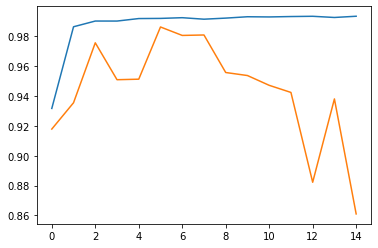

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

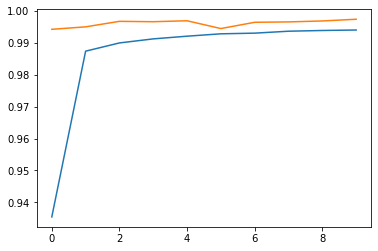

In [33]:
plt.plot(history_2.history['accuracy'])
plt.plot(history_2.history['val_accuracy'])

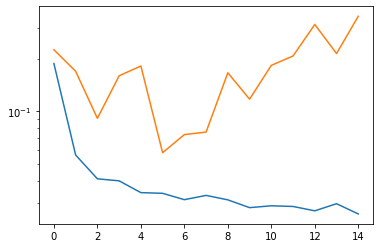

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')

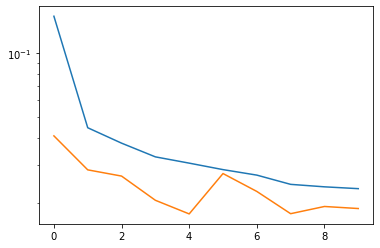

In [35]:


plt.plot(history_2.history['loss'])
plt.plot(history_2.history['val_loss'])
plt.yscale('log')

In [36]:
y_pred = CNN.predict(X_test)
# y_pred = model.predict(X_test)

525/525 [==============================] - 3s 6ms/step


In [37]:
y_pred_model = model.predict(X_test)
y_pred_model= np.argmax(y_pred_model, axis=1)

525/525 [==============================] - 2s 5ms/step


In [38]:
y_pred

array([[8.88802631e-08, 1.90754340e-15, 5.13288231e-11, 9.99999404e-01,
        4.42842264e-07],
       [9.81966853e-01, 1.79662872e-02, 2.15562013e-05, 7.35100980e-10,
        4.52467611e-05],
       [2.38447313e-07, 5.61985185e-15, 8.63631389e-11, 9.99998450e-01,
        1.33706897e-06],
       ...,
       [4.32120889e-01, 5.67600131e-01, 7.65532241e-05, 1.41411360e-09,
        2.02374009e-04],
       [2.73232604e-03, 9.97264981e-01, 2.70988266e-06, 3.06507389e-11,
        1.03219155e-09],
       [1.28846586e-15, 1.63529471e-19, 1.19165586e-20, 4.87249185e-10,
        1.00000000e+00]], dtype=float32)

In [39]:
y_pred= np.argmax(y_pred, axis=1)

In [40]:
y_pred

array([3, 0, 3, ..., 1, 1, 4])

In [41]:
y_pred[0]

3

In [42]:
df = pd.DataFrame({
    'y_test': y_test.ravel().astype(int).tolist(),
    'y_pred': y_pred.ravel().astype(int).tolist(),
})

In [43]:
df_model = pd.DataFrame({
    'y_test': y_test.ravel().astype(int).tolist(),
    'y_pred': y_pred_model.ravel().astype(int).tolist(),
})

In [44]:
pd.crosstab(df['y_test'], df['y_pred'])

y_pred,0,1,2,3,4
y_test,,,,,
0,4830,2168,0,0,199
1,23,2373,0,0,1
2,13,0,2384,0,0
3,0,0,0,2397,0
4,0,0,0,0,2397


In [45]:
pd.crosstab(df_model['y_test'], df_model['y_pred'])

y_pred,0,1,2,3,4
y_test,,,,,
0,7191,5,0,0,1
1,37,2360,0,0,0
2,13,0,2384,0,0
3,0,0,0,2397,0
4,0,0,0,0,2397


In [50]:
model.save('model_testar_1.h5')

In [49]:
CNN.save('model2testar_@.h5')